In [1]:
import os
os.chdir("/Users/User/P2")
print(os.getcwd())

C:\Users\User\P2


In [2]:
import pandas as pd
import numpy as np 

#load the data
data = pd.read_csv('SW_chl_nn-cleaned.csv')
print(data.shape)
print(data.info())

(1640, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1640 non-null   object 
 1   SW_chl_nn  1640 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB
None


In [3]:
# ADF Test = testing if data is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['SW_chl_nn'])

def adfuller_test(SW_chl_nn):
    result=adfuller(SW_chl_nn)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['SW_chl_nn'])


strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -6.141374519430604
p-value : 7.956189121093018e-08
#Lags Used : 13
Number of Observations : 1626


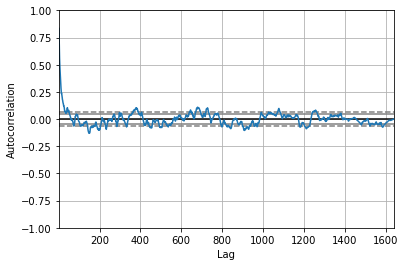

In [4]:
#autocorrelation

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline

autocorrelation_plot(data['SW_chl_nn'])
plt.show()

In [5]:
#divide into train and validation set
train = data[:int(0.7*(len(data)))]
valid = data[int(0.7*(len(data))):]

#preprocessing (since arima takes univariate series as input)
train.drop('Date',axis=1,inplace=True)
valid.drop('Date',axis=1,inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


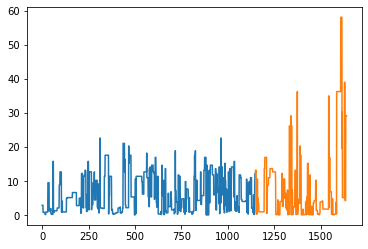

In [6]:
#plotting the data

train['SW_chl_nn'].plot()
valid['SW_chl_nn'].plot()

In [7]:
#building the model (with optimal p,d,q value)
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_fit=model.fit(train)

model_fit


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6060.936, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6029.093, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6023.504, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6058.943, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5943.757, Time=0.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6015.358, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6027.251, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5942.042, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6021.515, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6027.103, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1148
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2963.794
Date:                Mon, 24 Jan 2022   AIC                           5937.588
Time:                        08:28:10   BIC                           5962.812
Sample:                             0   HQIC                          5947.111
                               - 1148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0449      0.159      0.282      0.778      -0.267       0.356
ar.L2          0.5959      0.116      5.155      0.000       0.369       0.822
ma.L1         -0.2990      0.168     -1.775      0.076      -0.629       0.031
ma.L2         -0.6828      0.166     -4.118      0.000      -1.008      -0.358
sigma2        10.2622      0.285     36.015      0.000       9.704      10.821
===================================================================================
Ljung-Box (Q):                       29.60   Jarque-Bera (JB):              2858.60
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

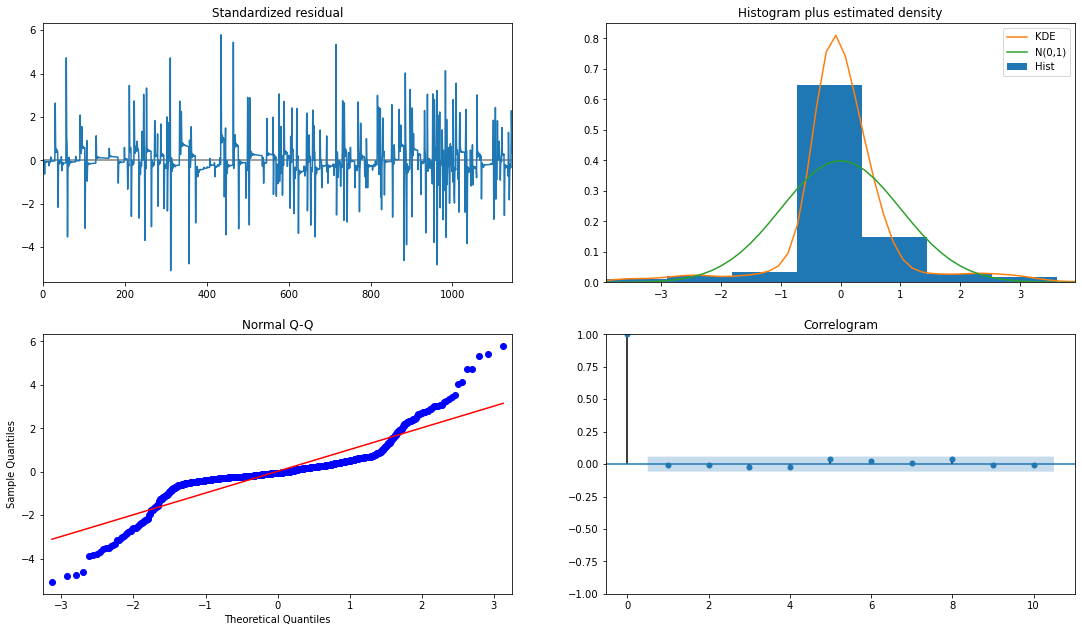

In [10]:
fig = model_fit.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)

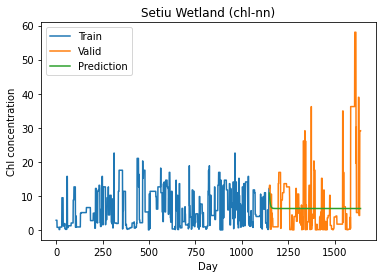

In [11]:
#plot the predictions for validation set

plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.xlabel("Day")
plt.ylabel("Chl concentration")
plt.legend(loc="upper left")
plt.title("Setiu Wetland (chl-nn)")
plt.show()

In [12]:
#model evaluation
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import r2_score


print('Mean Absolute Error:', metrics.mean_absolute_error(valid,forecast))
print('Mean Squared Error:', metrics.mean_squared_error(valid,forecast))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid,forecast)))
print('R Squared value:',r2_score(valid,forecast))

Mean Absolute Error: 7.40226496596509
Mean Squared Error: 129.371558836283
Root Mean Squared Error: 11.374161895994051
R Squared value: -0.018864667514508326
